In [2]:
import jax
import os
import numpy as np
import pandas as pd
import random
import json

class MaskSVDSimulator(object):
    def __init__(self, 
                 study_names: list,     # list of study names
                 sample_nums: list,     # list of numbers, the sample number of each studies
                 feature_dim: int,      # number of species
                 latent_dim: int,       # number of latent Sigma matrix
                 noise_ratio: float,    # noise ratio, ratio of E and Sigma
                 magnitude=10000,       # multiplier of Sigma to avoid too small values
                 avg_prop = 0.4,        # average proportion of features for a study to have among all feature 
                 V = None               # import V from another simulator
                 ):  
        
        self.study_names = study_names
        self.sample_nums = sample_nums
        self.feature_dim = feature_dim
        self.latent_dim = latent_dim
        self.noise_ratio = noise_ratio
        self.magnitude = magnitude
        self.avg_prop = avg_prop
        self.V = V

        self.num_of_studies = len(study_names)

        self.Xs = list()
        self.Us = list()
        self.Sigmas = list()
        self.Cs = list()
        self.X = None # an output dataframe 

    
    def _gen_random_ortho(self, n: int, k:int):
        random_matrix = np.random.rand(n, n)
        q, _ = np.linalg.qr(random_matrix)
        return q[:, :k]
    
    def _assign_features(self): # assign the considered features (species) for each study
        self.Cs = list()
        for i in range(self.num_of_studies):
            prop = np.random.uniform(0.8, 1.2) * self.avg_prop
            prop = np.min([prop, 1.0])
            study_feature_dim = round(self.feature_dim*prop)
            
            C_list = [1]*study_feature_dim + [0]*(self.feature_dim-study_feature_dim)
            random.shuffle(C_list)
            self.Cs.append(np.diag(C_list))

    def _clear_all(self, new_V = True):
        # new_V: True to delete the current V
        self.Xs = list()
        self.Us = list()
        self.Sigmas = list()
        self.Cs = list()
        self.X = None
        if new_V:
            self.V = None
    
    def _concat_Xs(self):
        assert len(self.Xs) == self.num_of_studies

        repeated_study_names = [self.study_names[i] for i in range(self.num_of_studies) for _ in range(self.sample_nums[i])]
        feature_names = [f'species_{i}' for i in range(self.feature_dim)]
        X = np.vstack(self.Xs)

        self.X = pd.DataFrame({'study_names': repeated_study_names, **dict(zip(feature_names, X.T))})
        type_dict = {'study_names': str}
        for col_names in self.X.columns[1:]:
            type_dict[col_names] = float
        self.X = self.X.astype(type_dict)
        return self.X
    
    def save(self, file_path):
        # save X, U, Sigma, V
        if not os.path.exists(file_path):
            os.makedirs(file_path)

        repeated_study_names = pd.DataFrame([self.study_names[i] for i in range(self.num_of_studies) for _ in range(self.sample_nums[i])])
        repeated_study_names.columns = ['study']
        repeated_study_names.to_csv(os.path.join(file_path, "sim_study_name.csv"), index=False)
        self.X.iloc[:, 1:].to_csv(os.path.join(file_path, "sim_matrix_data.csv"), index=False)
        
        X_dict = {}
        Sigma_dict = {}
        C_dict = {}
        U_dict =  {}
        V_dict = {}

        V_dict["V"] = self.V.tolist()
        for i, key in enumerate(self.study_names):
            X_dict[key] = self.Xs[i].tolist()
            Sigma_dict[key] = self.Sigmas[i].tolist()
            C_dict[key] = self.Cs[i].tolist()
            U_dict[key] = self.Us[i].tolist()
        with open(os.path.join(file_path, 'Xs.json'), 'w') as json_file:
            json.dump(X_dict, json_file)
        with open(os.path.join(file_path, 'Sigmas.json'), 'w') as json_file:
            json.dump(Sigma_dict, json_file)
        with open(os.path.join(file_path, 'Cs.json'), 'w') as json_file:
            json.dump(C_dict, json_file)
        with open(os.path.join(file_path, 'Us.json'), 'w') as json_file:
            json.dump(U_dict, json_file)
        with open(os.path.join(file_path, 'V.json'), 'w') as json_file:
            json.dump(V_dict, json_file)


    def simulate(self, new_V=False): # new_V means we remove the current V matrix and generate a new one
        self._clear_all(new_V=new_V)
        self._assign_features()
        if new_V or self.V is None: 
            self.V = self._gen_random_ortho(self.feature_dim, self.latent_dim)
        for i in range(self.num_of_studies):            
            # generate Sigma by an inverse gamma distribution
            alpha = np.random.uniform(2.0, 4.0)
            beta = np.random.uniform(0.5, 1.5)
            sigma_list = 1/np.random.gamma(alpha, scale=beta, size=self.latent_dim)
            sigma_list = np.sort(sigma_list)[::-1]

            Sigma = np.diag(self.magnitude * sigma_list)
            self.Sigmas.append(Sigma)

            # generate U
            U = self._gen_random_ortho(self.sample_nums[i], self.latent_dim)
            self.Us.append(U)

            # generate noise 
            noise_level = np.max(sigma_list) * self.noise_ratio
            E = np.random.normal(0, noise_level, size=(self.sample_nums[i], self.feature_dim))

            X = (U@Sigma@self.V.T+E)@self.Cs[i]
            self.Xs.append(X)

        assert self.X is None
        self._concat_Xs()
        return self.X

In [13]:
np.random.seed(1234)
random.seed(1234)

study_names = ['A', 'B', 'C', 'D', 'E']
sample_nums = [100, 150, 200, 250, 300]
feature_dim = 200
latent_dim = 20
noise_ratio = 0.01
magnitude = 10000

for i, avg_prop in enumerate(np.arange(0.1, 1.0, 0.1)):
    simulator = MaskSVDSimulator(study_names, sample_nums, feature_dim, latent_dim, noise_ratio, magnitude, avg_prop)
    X = simulator.simulate(new_V=True)
    save_path = f'./diff_prop_sim/avg_prop_{i+1}'
    simulator.save(save_path)

In [3]:
np.random.seed(1234)
random.seed(1234)

study_names = ['A', 'B', 'C', 'D', 'E']
sample_nums = [100, 150, 200, 250, 300]
feature_dim = 200
latent_dim = 20
noise_ratio_list = [0, 0.001, 0.01, 0.1, 1.0]
magnitude = 10000
avg_prop = 0.5

for i, noise_ratio in enumerate(noise_ratio_list):
    simulator = MaskSVDSimulator(study_names, sample_nums, feature_dim, latent_dim, noise_ratio, magnitude, avg_prop)
    X = simulator.simulate(new_V=True)
    save_path = f'./diff_noise/noise_{noise_ratio}'
    simulator.save(save_path)

In [5]:
np.arange(0.1, 0.9, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [66]:
simulator.save("testpath")

In [14]:
with open('./diff_prop_sim/avg_prop_5/Cs.json', 'r') as json_file:
    Cs = json.load(json_file)
    print(np.sum(Cs['A']))

111


In [16]:
for i in study_groundTruth.values():
    print(np.array(i).shape)

(100, 20)
(150, 20)
(200, 20)
(250, 20)
(300, 20)


In [7]:
simulator.Us[0]

array([[-0.01337171, -0.15450446, -0.02588538, ...,  0.19485194,
        -0.20371616, -0.21787846],
       [-0.0268284 , -0.00820776, -0.12209017, ..., -0.09362479,
         0.05321135, -0.06020095],
       [-0.12910671,  0.02012597, -0.09905339, ...,  0.07341435,
         0.14599687, -0.10600979],
       ...,
       [-0.04646537, -0.00853654, -0.20754668, ..., -0.10240266,
         0.06068617, -0.04208384],
       [-0.05276964,  0.03904246, -0.2002774 , ..., -0.12444684,
        -0.03007513, -0.02844404],
       [-0.03542893, -0.06236892,  0.01471159, ..., -0.00397532,
        -0.15057107, -0.04721932]])

In [8]:
X

,study_names,species_0,species_1,species_2,species_3,species_4,species_5,species_6,species_7,species_8,...,species_190,species_191,species_192,species_193,species_194,species_195,species_196,species_197,species_198,species_199
0,A,0.0,0.000000,0.000000,34.356181,-167.662137,0.000000,0.000000,0.000000,0.0,...,-73.429184,0.0,0.000000,-20.432785,0.0,-98.703865,-19.377769,-104.578326,0.000000,0.000000
1,A,0.0,0.000000,0.000000,33.600380,47.106899,0.000000,0.000000,0.000000,0.0,...,-11.935501,0.0,0.000000,99.368254,0.0,109.576911,-135.585032,32.135322,0.000000,0.000000
2,A,0.0,0.000000,0.000000,58.087023,126.726002,0.000000,0.000000,0.000000,0.0,...,-49.741688,0.0,0.000000,159.341898,0.0,106.896510,-60.837022,139.041361,0.000000,0.000000
3,A,0.0,0.000000,0.000000,227.470378,217.995551,0.000000,0.000000,0.000000,0.0,...,-55.037609,0.0,0.000000,289.205982,0.0,45.593714,43.469616,15.185265,0.000000,0.000000
4,A,0.0,0.000000,0.000000,166.733828,-78.042521,0.000000,0.000000,0.000000,0.0,...,-171.642181,0.0,0.000000,83.876391,0.0,33.388102,6.354781,-12.066581,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,E,0.0,28.236487,102.210089,0.000000,0.000000,137.391054,35.069384,-4.925718,0.0,...,0.000000,0.0,32.377146,0.000000,0.0,-74.957568,57.670154,-56.997587,18.853847,-17.912250
996,E,0.0,-8.789982,19.348201,0.000000,0.000000,29.680170,-29.096603,99.112102,0.0,...,0.000000,0.0,104.747941,0.000000,0.0,81.806682,-14.408070,14.951290,85.122452,104.374758
997,E,0.0,-88.847679,-142.788802,0.000000,0.000000,-47.884269,-36.669546,-116.089766,0.0,...,0.000000,0.0,67.970693,0.000000,0.0,-46.221539,43.314496,78.928098,55.698650,-54.082343
998,E,0.0,-12.410174,1.901680,0.000000,0.000000,28.402896,1.943371,37.575354,0.0,...,0.000000,0.0,92.121691,0.000000,0.0,50.070131,-65.787061,62.186463,14.085002,-2.522511


In [7]:
X_val = X.iloc[:, 1:].values

<Axes: >

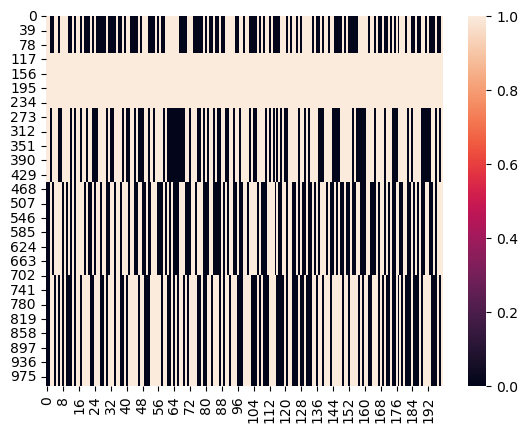

In [15]:
import seaborn as sns

sns.heatmap(X_val != 0)

<AxesSubplot:>

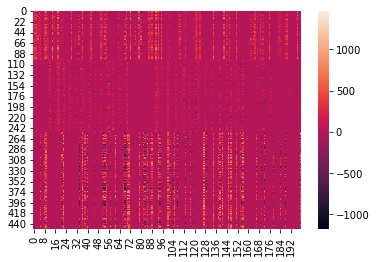

In [7]:
sns.heatmap(X_val)

In [10]:
X.iloc[:, 1:].to_csv("CRC_matrix_data.csv", index=False)

In [11]:
df_study_name = pd.DataFrame(X["study_names"])
df_study_name.rename(columns={'study_names': 'x'}, inplace=True)
df_study_name.to_csv("CRC_study_name.csv", index=False)

In [1]:
import numpy as np
from scipy.linalg import eig
p = 1/4
q = 3/4

A = np.array([[p,q,0,0,0,0],
              [q,0,p,0,0,0],
              [0,p,0,q,0,0],
              [0,0,q,0,p,0],
              [0,0,0,p,0,q],
              [0,0,0,0,q,p]])

val, vec = eig(A)


In [2]:
val

array([-0.90138782+0.j, -0.66143783+0.j, -0.5       +0.j,  0.66143783+0.j,
        1.        +0.j,  0.90138782+0.j])

In [3]:
vec

array([[ 0.22606222,  0.44515582, -0.40824829, -0.36765422,  0.40824829,
        -0.53125249],
       [-0.34704704, -0.54097581,  0.40824829, -0.20168914,  0.40824829,
        -0.46140187],
       [ 0.57310926,  0.09581999,  0.40824829,  0.56934336,  0.40824829,
        -0.06985062],
       [-0.57310926,  0.09581999, -0.40824829,  0.56934336,  0.40824829,
         0.06985062],
       [ 0.34704704, -0.54097581, -0.40824829, -0.20168914,  0.40824829,
         0.46140187],
       [-0.22606222,  0.44515582,  0.40824829, -0.36765422,  0.40824829,
         0.53125249]])